# ARIMA models analysis using LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import Dense, RNN
# my utils library
from ts_utils import stationary_check, tsplot

plt.rcParams['figure.figsize'] = 15, 8

Using TensorFlow backend.


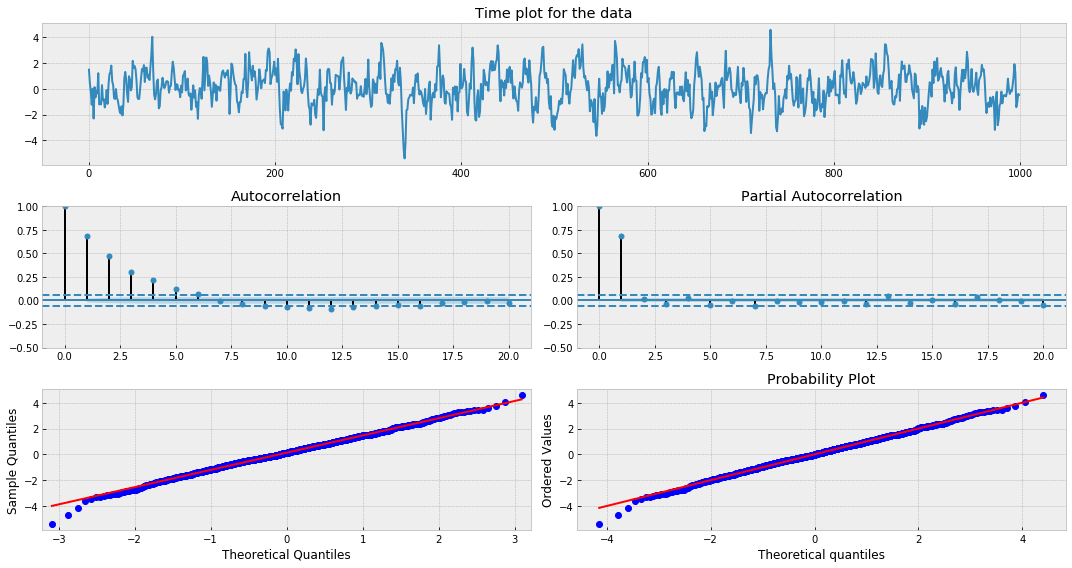

In [2]:
np.random.seed(1)
n_samples = 1000
data = noise = np.random.normal(size=1000)

# ar(1) model : x[t] = alpha * x[t-1] + noise

# case : 1, alpha = 0.5
alpha = 0.7
for t in range(len(data)):
    data[t] = alpha * data[t-1] + noise[t]

tsplot(data, lags=20, show=True)

In [3]:
def train_test_split(data, fraction=0.7):
    training = int(len(data)*fraction)
    train = data[0:training, 0].reshape(-1, 1)
    test = data[training:, 0].reshape(-1, 1)
    return train, test


def prepare_data(data, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(data)-time_step-1):
        dataX.append(data[i:(i+time_step), 0])
        dataY.append(data[i+time_step, 0])
    return np.array(dataX), np.array(dataY).reshape(-1, 1)

In [4]:
data = data.reshape(-1, 1)
print(data.shape)

(1000, 1)


In [5]:
# split the data into train and test samples
train, test = train_test_split(data, fraction=0.7)
print(len(train))
print(len(test))
print(train.shape)
print(test.shape)

700
300
(700, 1)
(300, 1)


In [6]:
# prepare the uni-variate data in the form of X, y
trainX, trainY = prepare_data(train, time_step=1)
testX, testY = prepare_data(test, time_step=1)

print(trainX.shape)
print(trainY.shape)

(698, 1)
(698, 1)


In [7]:
# create LSTM model
time_step = 1
features = 1
batch_size = None

# reshape the input in the form of [#samples, time step, features]
trainX = np.reshape(trainX, (trainX.shape[0], time_step, features))
testX = np.reshape(testX, (testX.shape[0], time_step, features))

In [8]:
from keras.models import Model
from keras.layers import Input
from keras import layers

In [9]:
ip = Input(batch_shape=(batch_size, 1, 1))
lstm = layers.LSTM(units=5)(ip)
dense = layers.Dense(1)(lstm)
model = Model(inputs=ip, output=dense)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


/Users/manish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [10]:
from keras import losses, optimizers

In [11]:
# training and model fitting
rms = optimizers.RMSprop(lr=0.01)
loss = losses.mean_squared_error
model.compile(optimizer=rms , loss=loss)
history = model.fit(trainX, trainY, batch_size=100, epochs=50, verbose=0, validation_split=0.05)

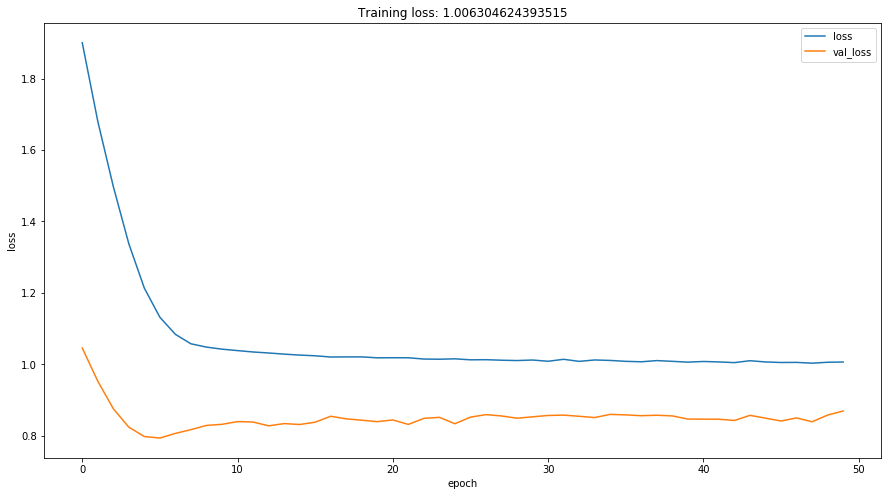

In [12]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training loss: {}".format(history.history["loss"][-1]))
plt.legend()
plt.show()

In [13]:
# model weights
model_weights = dict()
for layer in model.layers:
    model_weights[layer.name] = layer.get_weights()
    
print(model_weights)

{'input_1': [], 'lstm_1': [array([[ 0.7941077 , -0.41043034,  0.5834418 , -0.44862503, -0.65911096,
        -0.14487976, -0.20385942,  0.52018124, -0.36586863,  0.25060904,
        -0.27009445,  0.35118768,  0.2596018 , -0.3122917 ,  0.25188634,
         0.73421645, -0.41675448,  0.68426394, -0.456241  , -0.67786556]],
      dtype=float32), array([[ 0.1612173 , -0.22869115,  0.12023047, -0.01644484,  0.03591759,
         0.04866148, -0.14327376, -0.483722  ,  0.15894194,  0.2640602 ,
        -0.54257864,  0.01735974, -0.37501523, -0.01389513, -0.08164956,
        -0.22013018, -0.10251199,  0.1276458 , -0.17594038,  0.07360237],
       [ 0.02228673,  0.06715659,  0.11520124,  0.15128624,  0.36288607,
        -0.14012478, -0.05403806,  0.15369505,  0.03141133, -0.26904646,
        -0.07039162,  0.15425983,  0.11398856, -0.14929838, -0.2925361 ,
         0.20880291, -0.12186333,  0.04129782, -0.6960777 ,  0.1153576 ],
       [ 0.23058063,  0.30162305, -0.06015182,  0.14135228,  0.04838432

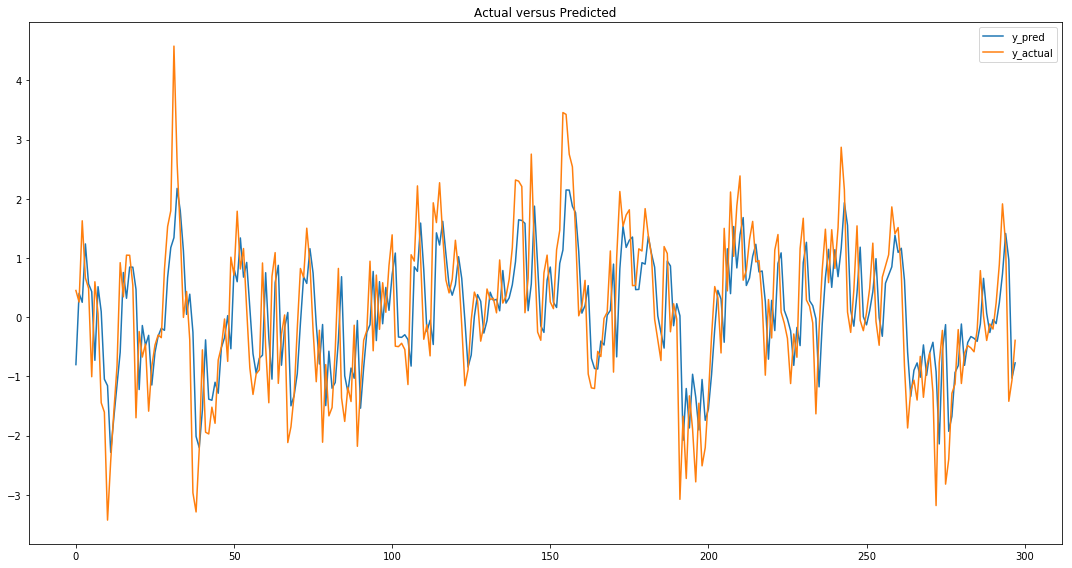

In [14]:
y_pred = model.predict(testX)
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.title('Actual versus Predicted')
plt.tight_layout()
plt.legend()
plt.show()

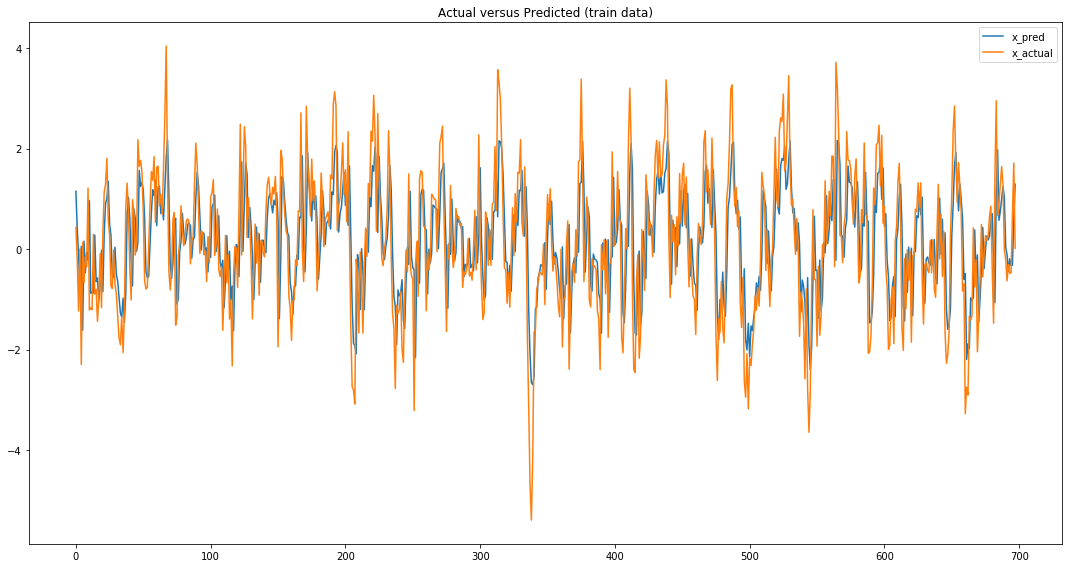

In [15]:
x_pred = model.predict(trainX)
plt.plot(x_pred, label = 'x_pred')
plt.plot(trainY, label = 'x_actual')
plt.title('Actual versus Predicted (train data)')
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
# extract the weight from rnn layer and plot the prediction result

lstm_model = Model(inputs=ip, outputs=lstm)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 140       
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


In [17]:
# as the model is already trained, we just have to 
# compile and extract the prediction from hidden layer
lstm_model.compile(optimizer=rms , loss=losses.mean_squared_error)

In [18]:
# the prediction for each sample 
# from every rnn unit
# as we have defined 5 rnn unit, so
# the shape of prediction is (sample size, #rnn_units)
lstm_predY = lstm_model.predict(testX)
print(lstm_predY.shape)

(298, 5)


In [19]:
# no sense of flatenning and visualizing the result
# it doesn't make any sense
# flatten_rnn_predY = rnn_predY.flatten()
# print(flatten_rnn_predY.shape)

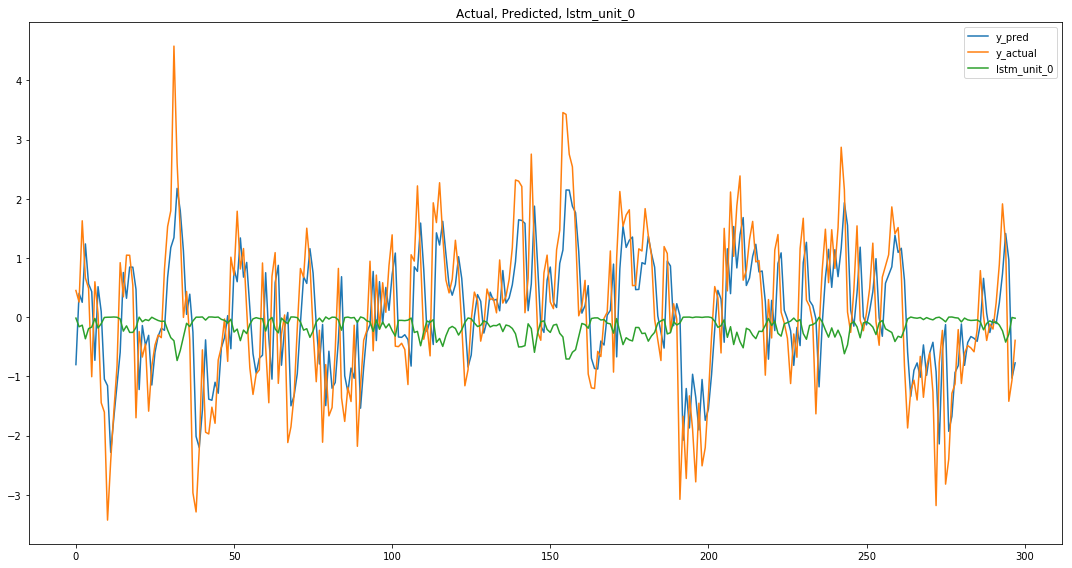

In [20]:
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.plot(lstm_predY[:, 0], label='lstm_unit_0')
plt.title('Actual, Predicted, lstm_unit_0')
plt.tight_layout()
plt.legend()
plt.show()

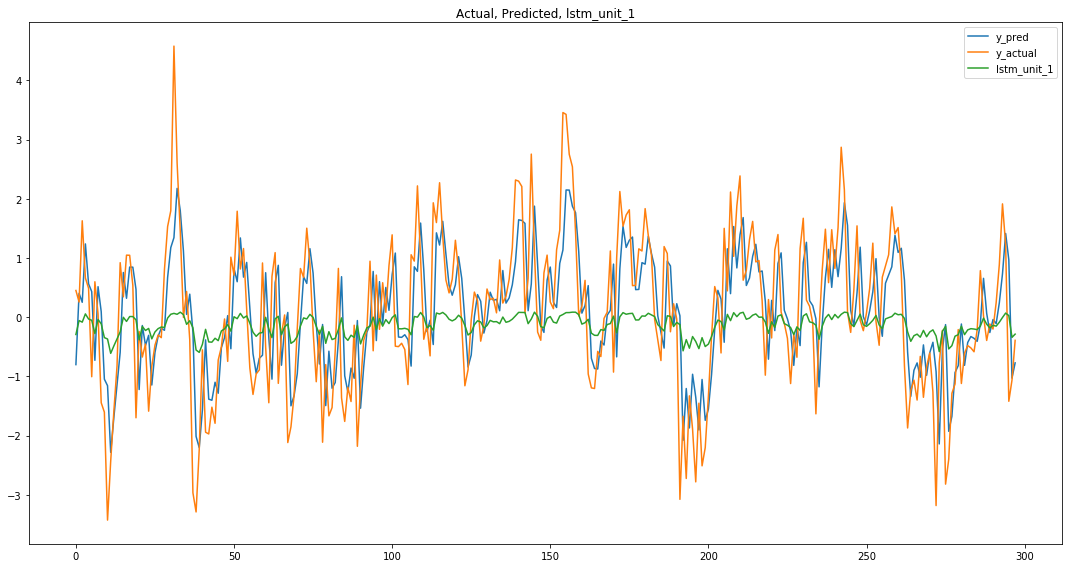

In [21]:
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.plot(lstm_predY[:, 1], label='lstm_unit_1')
plt.title('Actual, Predicted, lstm_unit_1')
plt.tight_layout()
plt.legend()
plt.show()

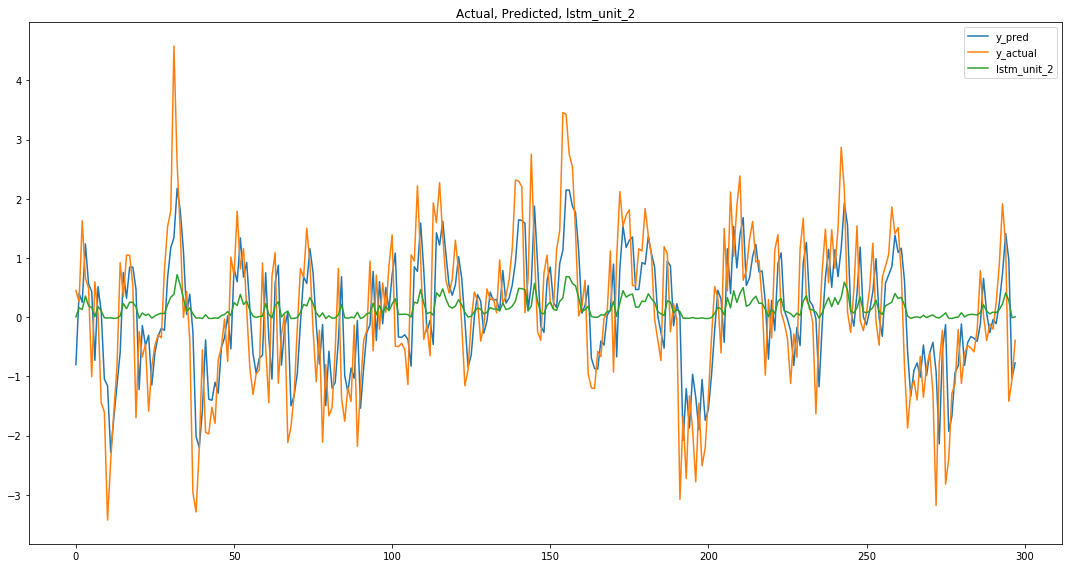

In [22]:
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.plot(lstm_predY[:, 2], label='lstm_unit_2')
plt.title('Actual, Predicted, lstm_unit_2')
plt.tight_layout()
plt.legend()
plt.show()

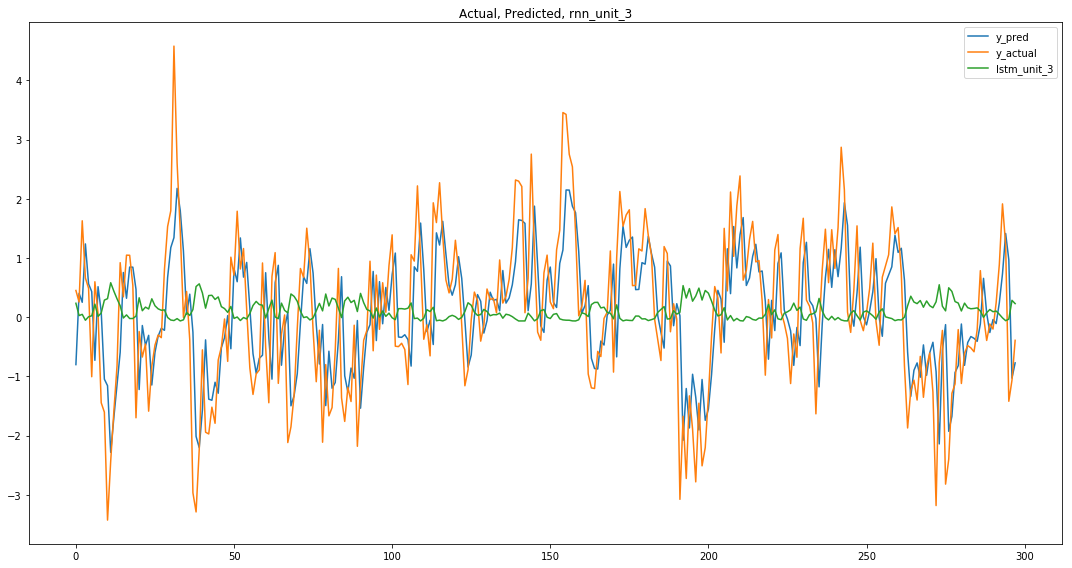

In [23]:
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.plot(lstm_predY[:, 3], label='lstm_unit_3')
plt.title('Actual, Predicted, rnn_unit_3')
plt.tight_layout()
plt.legend()
plt.show()

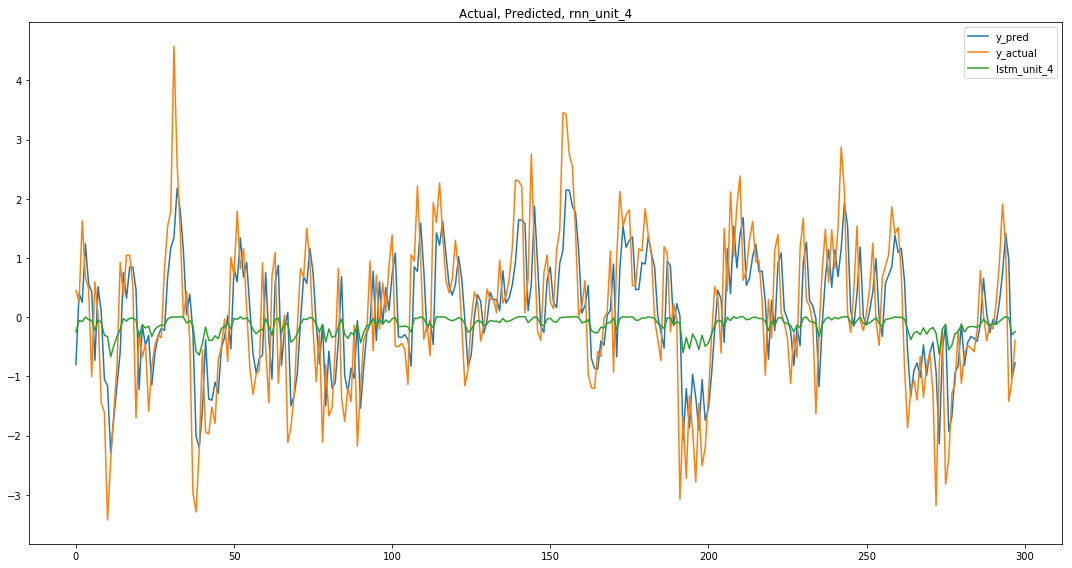

In [24]:
plt.plot(y_pred, label = 'y_pred')
plt.plot(testY, label = 'y_actual')
plt.plot(lstm_predY[:, 4], label='lstm_unit_4')
plt.title('Actual, Predicted, rnn_unit_4')
plt.tight_layout()
plt.legend()
plt.show()